# Pre processing for skin lesion dataset

In [1]:
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import FunctionTransformer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomBrightness


In [2]:
# Visualização
def show_images(img_list, titles=None):
    """
    Função auxiliar para exibir uma lista de imagens.

    Args:
        img_list (list): Lista de imagens a serem exibidas.
        titles (list, optional): Lista de títulos para cada imagem. Defaults to None.
    """
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(img_list):
        plt.subplot(1, len(img_list), i+1)
        plt.imshow(img, cmap='viridis')
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Etapa 1.1: Redimensionamento
class Resize(BaseEstimator, TransformerMixin):
    """
    Redimensiona as imagens para um tamanho fixo.
    
    Args:
        size (tuple, optional): O tamanho para o qual as imagens serão redimensionadas.
            Defaults to (128, 128).
    """
    def __init__(self, size=(128, 128)):
        self.size = size
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([cv2.resize(img, self.size) for img in X])

# Etapa 1.2: Normalização
class Normalize(BaseEstimator, TransformerMixin):
    def __init__(self, scaling='minmax'):
        """
        Normaliza as imagens.

        Args:
            scaling (str, optional): O tipo de escalonamento a ser aplicado.
                'minmax': Escala os valores para o intervalo [0, 1].
                'meanstd': Centraliza os dados com média zero e desvio padrão unitário (por canal).
                Defaults to 'minmax'.
        """
        self.scaling = scaling
        self.mean = None
        self.std = None

    def fit(self, X):
        if self.scaling == 'meanstd':
            # Calcula a média e o desvio padrão por canal para o conjunto de treinamento
            X = np.array(X)
            if X.ndim == 4: 
                self.mean = np.mean(X, axis=(0, 1, 2), keepdims=True)
                self.std = np.std(X, axis=(0, 1, 2), keepdims=True)
            elif X.ndim == 3: 
                self.mean = np.mean(X, axis=(0, 1), keepdims=True)
                self.std = np.std(X, axis=(0, 1), keepdims=True)
            else:
                raise ValueError("Formato de entrada não suportado para 'meanstd' scaling.")
        return self

    def transform(self, X):
        X = np.array(X, dtype=np.float32)
        if self.scaling == 'minmax':
            min_val = np.min(X)
            max_val = np.max(X)
            # Evita divisão por zero se min_val == max_val
            return (X - min_val) / (max_val - min_val + 1e-8)
        elif self.scaling == 'meanstd':
            if self.mean is None or self.std is None:
                raise ValueError("O método 'fit' deve ser chamado antes de 'transform' com scaling='meanstd'.")
            return (X - self.mean) / (self.std + 1e-8)
        else:
            raise ValueError(f"Tipo de escalonamento '{self.scaling}' não suportado.")
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
# Etapa 2: Filtro Gaussiano (remoção de ruído)
class GaussianBlur(BaseEstimator, TransformerMixin):
    """
    Aplica um filtro gaussiano para remoção de ruído.
    
    Args:
        ksize (tuple, optional): Tamanho do kernel gaussiano. Defaults to (5, 5).
        sigma (float, optional): Desvio padrão da distribuição gaussiana. Defaults to 0.
    """
    def __init__(self, ksize=(5, 5), sigma=0):
        self.ksize = ksize
        self.sigma = sigma

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([cv2.GaussianBlur(img, self.ksize, self.sigma) for img in X])

# Etapa 3  (versão 1): CLAHE (Equalização de histograma adaptativa)
class CLAHE(BaseEstimator, TransformerMixin):
    """
    Aplica CLAHE (Contrast Limited Adaptive Histogram Equalization) em imagens.

    Args:
        clip_limit (float, optional): Limite de recorte para CLAHE. Defaults to 2.0.
        tile_grid_size (tuple, optional): Tamanho da grade para CLAHE. Defaults to (8, 8).
    """
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([self.clahe.apply(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) for img in X])

# Etapa 3 (versão 2): CLAHE aplicado em cada canal de cor (BGR)
class CLAHE_Color(BaseEstimator, TransformerMixin):
    """
    Aplica CLAHE em cada canal de cor (BGR) de uma imagem.

    Args:
        clip_limit (float, optional): Limite de recorte para CLAHE. Defaults to 2.0.
        tile_grid_size (tuple, optional): Tamanho da grade para CLAHE. Defaults to (8, 8).
    """
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        processed_images = []
        for img in X:
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            cl = clahe.apply(l)
            merged_lab = cv2.merge((cl, a, b))
            processed_img = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)
            processed_images.append(processed_img)
        return np.array(processed_images)

# Etapa 4: Segmentação simples usando Otsu
class OtsuThreshold(BaseEstimator, TransformerMixin):
    """
    Aplica o método de Otsu para segmentação de imagens.

    Args:
        threshold (int, optional): Valor do limiar. Defaults to 0.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        binarized = []
        for img in X:
            if len(img.shape) == 3:  # Converte se for imagem colorida
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            binarized.append(binary)
        return binarized


## Testando as técnicas que implementamos

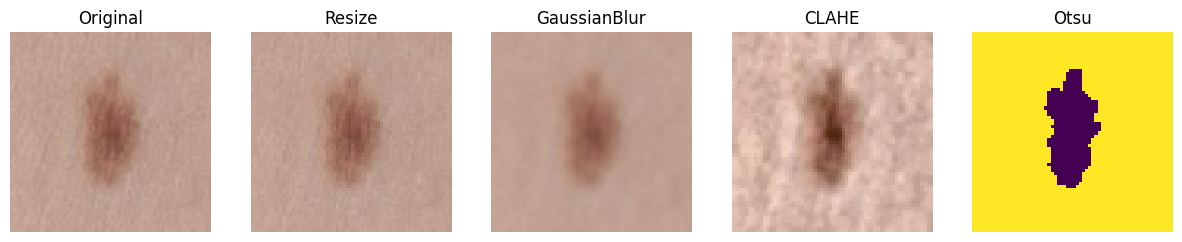

In [25]:
img_path = '../data/03_primary/ISIC_2024/images/ISIC_0087605.jpg'
original = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

step1_0 = Resize((64, 64)).fit_transform([original])
step2 = GaussianBlur((3, 3)).fit_transform(step1_0)
step3 = CLAHE_Color().fit_transform(step2)
step4 = OtsuThreshold().fit_transform(step3)

show_images([original, step1_0[0], step2[0], step3[0], step4[0]],
            titles=["Original", "Resize", "GaussianBlur", "CLAHE", "Otsu"])

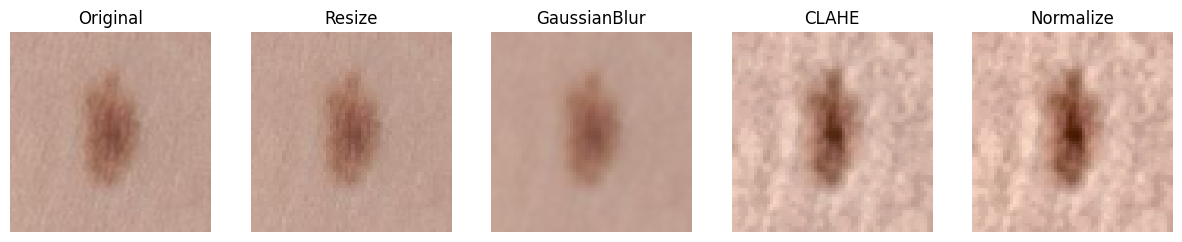

In [3]:
img_path = '../data/03_primary/ISIC_2024/images/ISIC_0087605.jpg'
original = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

step1 = Resize((64, 64)).fit_transform([original])
step2 = GaussianBlur((3, 3)).fit_transform(step1)
step3 = CLAHE_Color().fit_transform(step2)
step4 = Normalize().fit_transform(step3)

show_images([original, step1[0], step2[0], step3[0], step4[0]],
            titles=["Original", "Resize", "GaussianBlur", "CLAHE", "Normalize"])

# Carregando dataset completo

In [3]:
y_true = pd.read_csv('../data/03_primary/ISIC_2024/label.csv')
#y_true = y_true.iloc[:, 1].values
y_true[y_true.malignant == 1]

,isic_id,malignant
387,ISIC_0082829,1.0
935,ISIC_0096034,1.0
1245,ISIC_0104229,1.0
1846,ISIC_0119495,1.0
3478,ISIC_0157834,1.0
...,...,...
396165,ISIC_9877311,1.0
398671,ISIC_9941636,1.0
399936,ISIC_9972649,1.0
399943,ISIC_9972877,1.0


In [5]:
# ---------- Dataset ----------
base_path = r'..\data\03_primary\ISIC_2024'
image_folder = os.path.join(base_path, 'images')
csv_path = os.path.join(base_path, 'ISIC_2024_Permissive_Training_GroundTruth.csv')

# Lendo o CSV com os rótulos
df = pd.read_csv(csv_path)

# Separando as classes
df_class_1 = df[df['malignant'] == 1]
df_class_0 = df[df['malignant'] == 0]

# Amostragem da classe 0
df_class_0_sample = df_class_0.sample(n=len(df_class_1), random_state=42)

# Concatenando
df_sample = pd.concat([df_class_1, df_class_0_sample]).reset_index(drop=True)

# Função para carregar uma imagem
def load_image(filename, target_size=(128, 128)):
    img_path = os.path.join(image_folder, filename)
    img = cv2.imread(img_path+'.jpg')
    if img is None:
        print(f"Erro ao carregar a imagem: {img_path+'.jpg'}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img

# Carregando imagens e labels
images = []
labels = []

for _, row in df_sample.iterrows():
    img = load_image(row['isic_id'])
    if img is not None:
        images.append(img)
        labels.append(row['malignant'])


X = np.array(images)
y = np.array(labels)

In [6]:
# Converte os rótulos em one-hot encoding (se necessário)
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)

# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)


# Comprovando se houve melhora ou piora com uso de determinada técnica

In [7]:
def create_cnn_model(input_shape, num_classes=2):
    """Cria um modelo CNN.
    Args:
        X_train (numpy.ndarray): Conjunto de dados de treinamento.
        num_classes (int): Número de classes.  
    Returns:
        model (keras.Sequential): Modelo CNN compilado.
    """

    data_augmentation = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.1),
        RandomZoom(0.1),
        RandomBrightness(0.1),
    ])

    model = Sequential([
        data_augmentation,
        Rescaling(1./255),
        Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'Precision', 'Recall'])

    return model

In [8]:
model = create_cnn_model(X_train.shape[1:], num_classes)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


Epoch 1/10


c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 464ms/step - Precision: 0.4723 - Recall: 0.5691 - accuracy: 0.4539 - loss: 0.8741 - val_Precision: 0.4362 - val_Recall: 0.4362 - val_accuracy: 0.4362 - val_loss: 0.7004
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - Precision: 0.5521 - Recall: 0.5453 - accuracy: 0.5477 - loss: 0.6927 - val_Precision: 0.4362 - val_Recall: 0.4362 - val_accuracy: 0.4362 - val_loss: 0.6957
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - Precision: 0.5594 - Recall: 0.4854 - accuracy: 0.5174 - loss: 0.6907 - val_Precision: 0.4362 - val_Recall: 0.4362 - val_accuracy: 0.4362 - val_loss: 0.6943
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - Precision: 0.5373 - Recall: 0.5257 - accuracy: 0.5421 - loss: 0.6678 - val_Precision: 0.5870 - val_Recall: 0.2872 - val_accuracy: 0.6064 - val_loss: 0.6870
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - Precision: 0.6375 - Recall: 0.4149 - accuracy: 0.6329 - loss: 0.6782 - val_Precision: 0.7342 - val_Recall: 0.6170 - v

In [ ]:

mask = (y.flatten() == 0) | (y.flatten() == 1)
X = X[mask]
y = y[mask]
y = y.flatten()

preprocess_pipeline = Pipeline([
    ('resize', Resize((64, 64))),
    ('blur', GaussianBlur()),
    ('clahe', CLAHE())
])

X_processed = preprocess_pipeline.fit_transform(X)
X_processed = np.array(X_processed) / 255.0  # normalizando
X_processed = np.expand_dims(X_processed, axis=-1)

# ---------- Train/Test split ----------
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = create_cnn_model(X_train.shape[1:], num_classes)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# ---------- Avaliação ----------
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5142 - loss: 0.7033 - val_accuracy: 0.4894 - val_loss: 0.6942
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5290 - loss: 0.6918 - val_accuracy: 0.4894 - val_loss: 0.6921
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4890 - loss: 0.6915 - val_accuracy: 0.5532 - val_loss: 0.6899
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6007 - loss: 0.6880 - val_accuracy: 0.5319 - val_loss: 0.6841
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5601 - loss: 0.6824 - val_accuracy: 0.4894 - val_loss: 0.7188
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        53
         1.0       0.55      1.00      0.71        65

    accuracy                           0.55       118
   macro avg       0.28      0.50      0.36       118
weighted avg       0.30      0.55      0.39       118



c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

---> Testando Pipeline 1: Normalize 
Epoch 1/20


c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - Precision: 0.4782 - Recall: 0.4235 - accuracy: 0.4431 - loss: 0.8281 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - Precision: 0.5015 - Recall: 0.4872 - accuracy: 0.4948 - loss: 0.6905 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.8483
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - Precision: 0.5272 - Recall: 0.5345 - accuracy: 0.5095 - loss: 0.7560 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6906
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - Precision: 0.5096 - Recall: 0.5316 - accuracy: 0.5040 - loss: 0.6941 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - Precision: 0.4713 - Recall: 0.4912 - accuracy: 0.4690 - loss: 0.6967 - val_Precision: 0.5000 - val_Recall: 0.5000 - v

c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - Precision: 0.4917 - Recall: 0.4954 - accuracy: 0.5278 - loss: 0.8326 - val_Precision: 0.5043 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6899
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - Precision: 0.5664 - Recall: 0.5452 - accuracy: 0.5644 - loss: 0.6854 - val_Precision: 0.5739 - val_Recall: 0.5593 - val_accuracy: 0.5678 - val_loss: 0.6853
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - Precision: 0.5807 - Recall: 0.5746 - accuracy: 0.5803 - loss: 0.6826 - val_Precision: 0.5083 - val_Recall: 0.5169 - val_accuracy: 0.5085 - val_loss: 0.6928
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - Precision: 0.4829 - Recall: 0.4829 - accuracy: 0.4829 - loss: 0.6934 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - Precision: 0.5099 - Recall: 0.5099 - accuracy: 0.5099 - loss: 0.6928 - val_Precision: 0.5000 - val_Recall: 0.5000 - v

c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - Precision: 0.4908 - Recall: 0.5200 - accuracy: 0.4766 - loss: 1.0786 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - Precision: 0.4902 - Recall: 0.5606 - accuracy: 0.4812 - loss: 0.6964 - val_Precision: 0.6286 - val_Recall: 0.1864 - val_accuracy: 0.6525 - val_loss: 0.6871
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - Precision: 0.5990 - Recall: 0.4879 - accuracy: 0.5894 - loss: 0.6837 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.7133
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - Precision: 0.5251 - Recall: 0.5431 - accuracy: 0.5273 - loss: 0.6969 - val_Precision: 0.5827 - val_Recall: 0.6271 - val_accuracy: 0.6102 - val_loss: 0.6629
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - Precision: 0.6176 - Recall: 0.6896 - accuracy: 0.6477 - loss: 0.6509 - val_Precision: 0.5000 - val_Recall: 0.5000 - v

c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 551ms/step - Precision: 0.4894 - Recall: 0.4907 - accuracy: 0.4799 - loss: 1.3142 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6953
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - Precision: 0.5203 - Recall: 0.4814 - accuracy: 0.5142 - loss: 0.7021 - val_Precision: 0.5625 - val_Recall: 0.6102 - val_accuracy: 0.5763 - val_loss: 0.6881
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - Precision: 0.5270 - Recall: 0.5745 - accuracy: 0.5279 - loss: 0.6913 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - Precision: 0.5054 - Recall: 0.5014 - accuracy: 0.5062 - loss: 0.6929 - val_Precision: 0.5042 - val_Recall: 0.5085 - val_accuracy: 0.5085 - val_loss: 0.6930
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - Precision: 0.5013 - Recall: 0.5058 - accuracy: 0.5020 - loss: 0.6931 - val_Precision: 0.5000 - val_Recall

c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step - Precision: 0.4755 - Recall: 0.4912 - accuracy: 0.4650 - loss: 0.7262 - val_Precision: 0.5000 - val_Recall: 0.5085 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - Precision: 0.5373 - Recall: 0.5459 - accuracy: 0.5373 - loss: 0.6918 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6915
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - Precision: 0.4775 - Recall: 0.4518 - accuracy: 0.4820 - loss: 0.6976 - val_Precision: 0.6344 - val_Recall: 0.5000 - val_accuracy: 0.5932 - val_loss: 0.6877
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - Precision: 0.5176 - Recall: 0.4815 - accuracy: 0.5179 - loss: 0.6935 - val_Precision: 0.6721 - val_Recall: 0.6949 - val_accuracy: 0.6695 - val_loss: 0.6785
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - Precision: 0.5482 - Recall: 0.5316 - accuracy: 0.5469 - loss: 0.6885 - val_Precision: 0.5000 - val_Recall: 

c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - Precision: 0.5188 - Recall: 0.5901 - accuracy: 0.5174 - loss: 0.7199 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - Precision: 0.5312 - Recall: 0.6317 - accuracy: 0.5331 - loss: 0.6929 - val_Precision: 0.5130 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6814
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - Precision: 0.5505 - Recall: 0.5255 - accuracy: 0.5562 - loss: 0.6867 - val_Precision: 0.5798 - val_Recall: 0.5847 - val_accuracy: 0.5763 - val_loss: 0.6755
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - Precision: 0.5557 - Recall: 0.5748 - accuracy: 0.5690 - loss: 0.6846 - val_Precision: 0.6829 - val_Recall: 0.7119 - val_accuracy: 0.6864 - val_loss: 0.6482
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - Precision: 0.5783 - Recall: 0.6032 - accuracy: 0.6036 - loss: 0.6755 - val_Precision: 0.7069 - val_Recall: 0.6949 - val_a

c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - Precision: 0.4984 - Recall: 0.5533 - accuracy: 0.4890 - loss: 0.7301 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - Precision: 0.4731 - Recall: 0.4638 - accuracy: 0.4794 - loss: 0.6940 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - Precision: 0.6045 - Recall: 0.6148 - accuracy: 0.6036 - loss: 0.6770 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6800
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - Precision: 0.5551 - Recall: 0.5569 - accuracy: 0.5572 - loss: 0.6807 - val_Precision: 0.6695 - val_Recall: 0.6695 - val_accuracy: 0.6610 - val_loss: 0.6517
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - Precision: 0.6678 - Recall: 0.6743 - accuracy: 0.6683 - loss: 0.6404 - val_Precision: 0.6772 - val_Recall: 0.7288 - val_a

c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - Precision: 0.5047 - Recall: 0.4953 - accuracy: 0.4958 - loss: 0.7553 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6906
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - Precision: 0.5234 - Recall: 0.4906 - accuracy: 0.5329 - loss: 0.6896 - val_Precision: 0.6833 - val_Recall: 0.3475 - val_accuracy: 0.6017 - val_loss: 0.6889
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - Precision: 0.5093 - Recall: 0.5368 - accuracy: 0.5110 - loss: 0.6899 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.7109
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - Precision: 0.5005 - Recall: 0.5076 - accuracy: 0.5011 - loss: 0.6928 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - Precision: 0.4874 - Recall: 0.5324 - accuracy: 0.4752 - loss: 0.6949 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_a

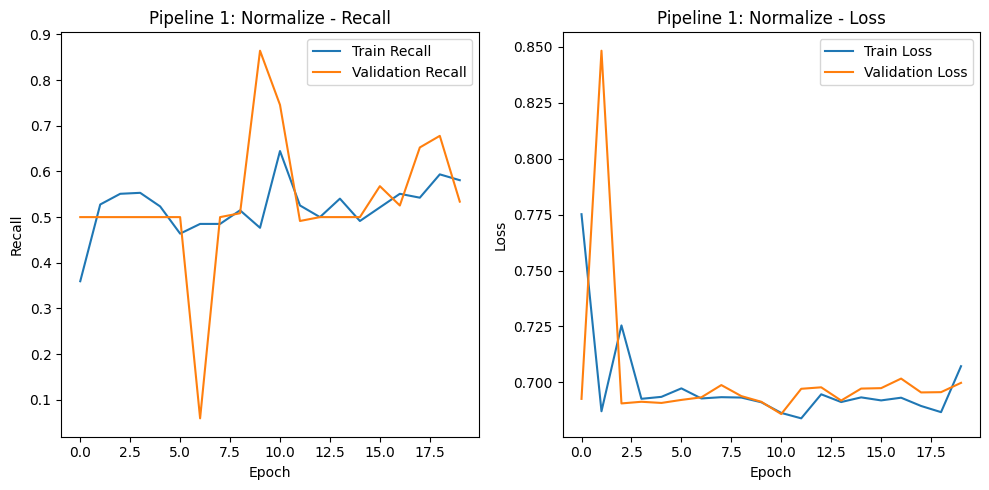

Pipeline 2: GaussianBlur -> Normalize:
  Acurácia: 0.4915
  Precisão: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  AUC: 0.5096


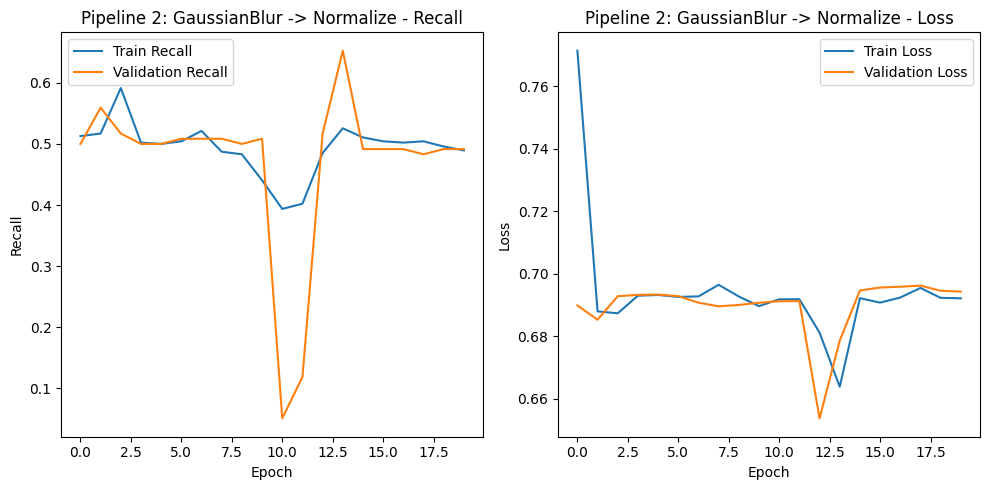

Pipeline 3: GaussianBlur -> CLAHE (Color) -> Normalize:
  Acurácia: 0.7203
  Precisão: 0.6548
  Recall: 0.9322
  F1-Score: 0.7692
  AUC: 0.8509


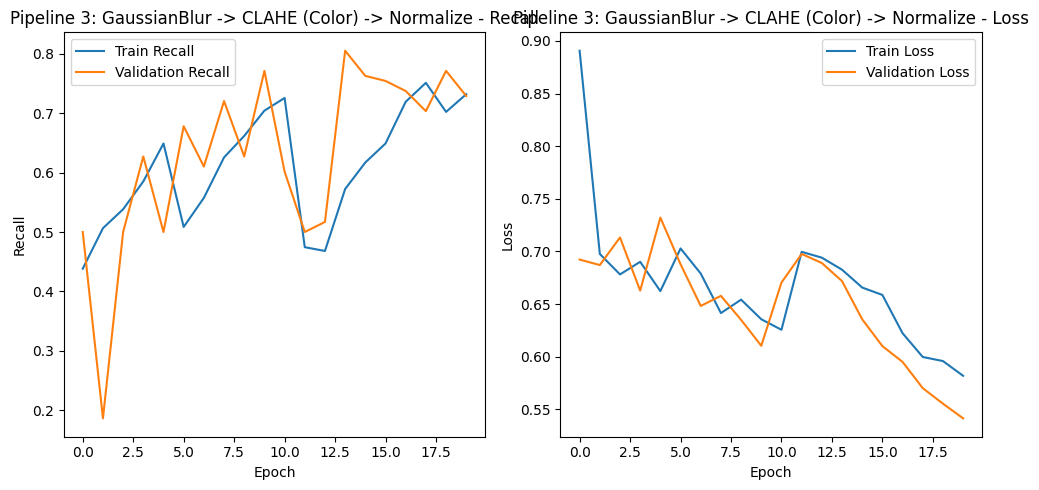

Pipeline 4: CLAHE (Color) -> Normalize:
  Acurácia: 0.5508
  Precisão: 0.8750
  Recall: 0.1186
  F1-Score: 0.2090
  AUC: 0.5148


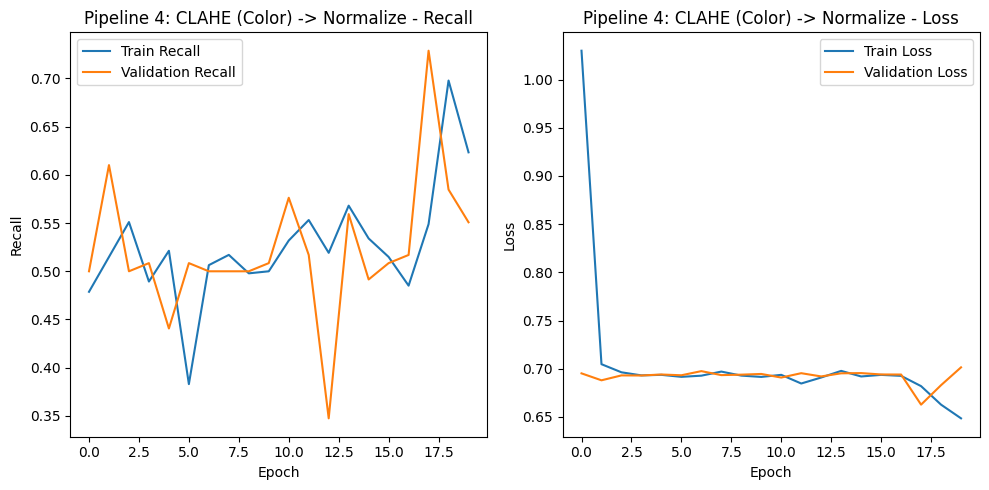

Pipeline 5: Resize -> Normalize:
  Acurácia: 0.7373
  Precisão: 0.9375
  Recall: 0.5085
  F1-Score: 0.6593
  AUC: 0.8569


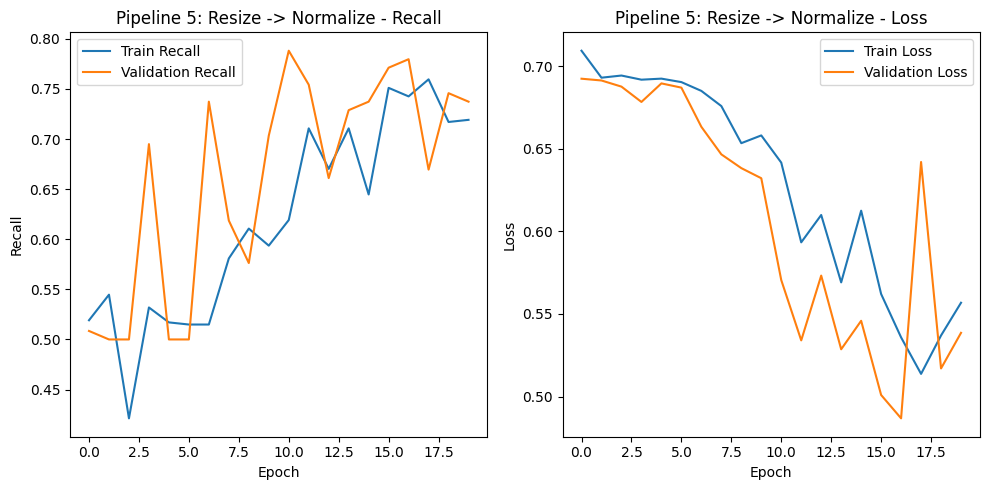

Pipeline 6: Resize -> GaussianBlur -> Normalize:
  Acurácia: 0.7712
  Precisão: 0.7500
  Recall: 0.8136
  F1-Score: 0.7805
  AUC: 0.8621


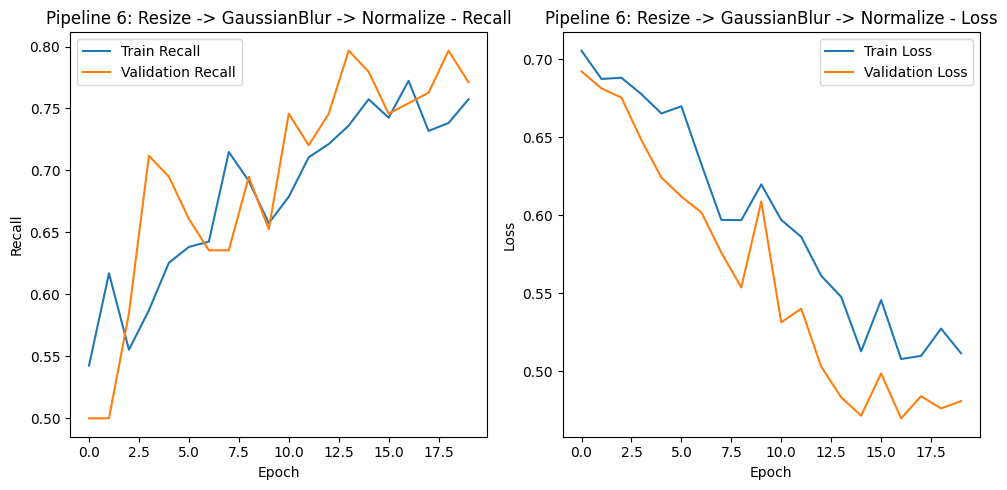

Pipeline 7: Resize -> GaussianBlur -> CLAHE (Color) -> Normalize:
  Acurácia: 0.8051
  Precisão: 0.8462
  Recall: 0.7458
  F1-Score: 0.7928
  AUC: 0.8584


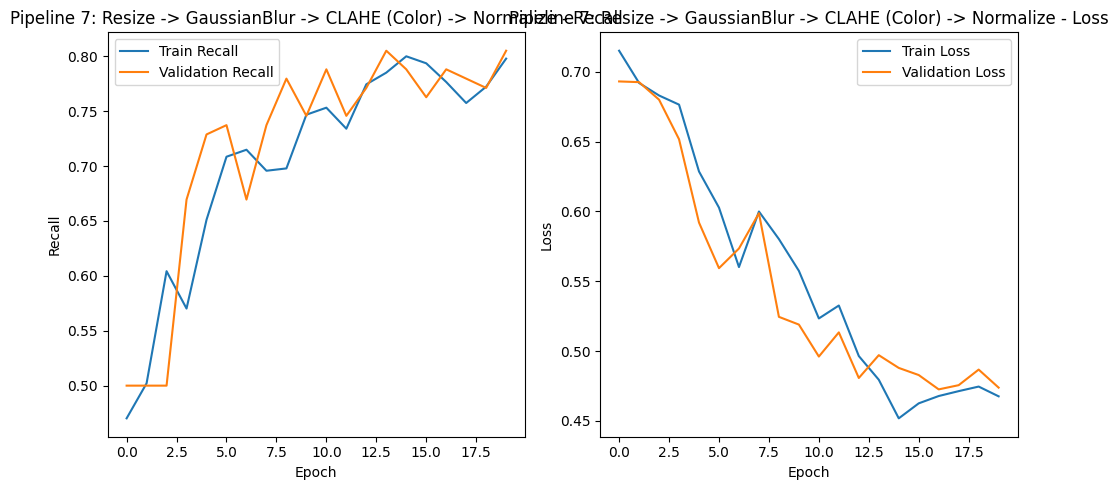

Pipeline 8: Resize -> CLAHE (Color) -> Normalize:
  Acurácia: 0.7034
  Precisão: 0.6463
  Recall: 0.8983
  F1-Score: 0.7518
  AUC: 0.8452


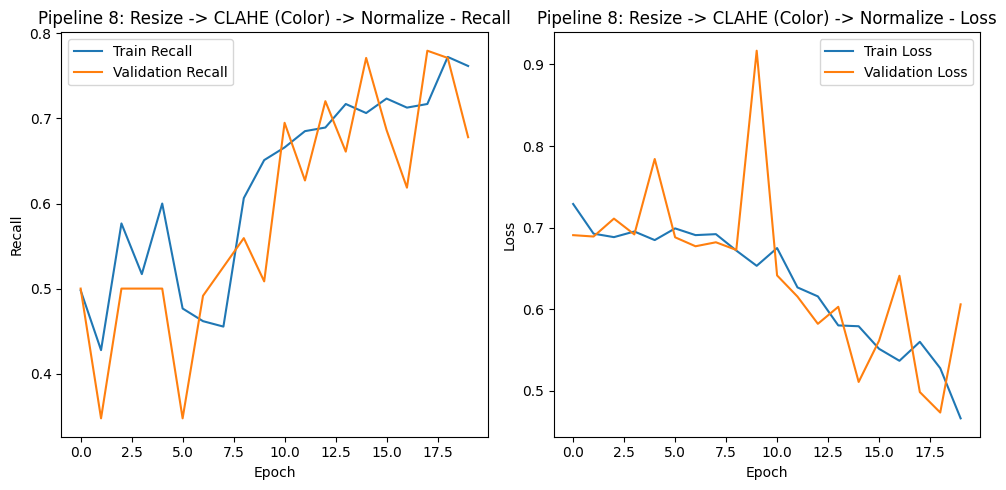


--- O melhor pipeline é o: (Pipeline 3: GaussianBlur -> CLAHE (Color) -> Normalize) ---


In [9]:
pipelines = {
    'Pipeline 1: Normalize': Pipeline([('noop', FunctionTransformer())]) ,
    'Pipeline 2: GaussianBlur -> Normalize': Pipeline([
        ('blur', GaussianBlur())
    ]),
    'Pipeline 3: GaussianBlur -> CLAHE (Color) -> Normalize': Pipeline([
        ('blur', GaussianBlur()),
        ('clahe', CLAHE_Color())
    ]),
    'Pipeline 4: CLAHE (Color) -> Normalize': Pipeline([
        ('clahe', CLAHE_Color())
    ]),
    'Pipeline 5: Resize -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
    ]),
    'Pipeline 6: Resize -> GaussianBlur -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
        ('blur', GaussianBlur())
    ]),
    'Pipeline 7: Resize -> GaussianBlur -> CLAHE (Color) -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
        ('blur', GaussianBlur()),
        ('clahe', CLAHE_Color())
    ]),
    'Pipeline 8: Resize -> CLAHE (Color) -> Normalize': Pipeline([
        ('resize', Resize((64, 64))),
        ('clahe', CLAHE_Color())
    ])
}

results = {}
epochs = 20
batch_size = 32

for name, pipeline in pipelines.items():
    
    print(f"---> Testando {name} ")
    X_train_processed_base = pipeline.fit_transform(X_train, y_train)
    X_test_processed_base = pipeline.transform(X_test)

    input_shape = X_train_processed_base.shape[1:]
    model = create_cnn_model(input_shape)

    history = model.fit(
        X_train_processed_base, y_train,
        validation_data=(X_test_processed_base, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    y_pred_test_prob = model.predict(X_test_processed_base)
    y_pred_test = (y_pred_test_prob > 0.5).astype(int)[:, 1]

    accuracy_aug = accuracy_score(y_test[:, 1], y_pred_test)
    precision_aug = precision_score(y_test[:, 1], y_pred_test)
    recall_aug = recall_score(y_test[:, 1], y_pred_test)
    f1_aug = f1_score(y_test[:, 1], y_pred_test)
    auc_aug = roc_auc_score(y_test[:, 1], y_pred_test_prob[:, 1])

    results[name] = {
        'accuracy': accuracy_aug,
        'precision': precision_aug,
        'recall': recall_aug,
        'f1': f1_aug,
        'auc': auc_aug,
        'history': history.history
    }

print("\n--- Resultados da Validação ---")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Acurácia: {metrics['accuracy']:.4f}")
    print(f"  Precisão: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1']:.4f}")
    print(f"  AUC: {metrics['auc']:.4f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['history']['Recall'], label='Train Recall')
    plt.plot(metrics['history']['val_Recall'], label='Validation Recall')
    plt.title(f'{name} - Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['history']['loss'], label='Train Loss')
    plt.plot(metrics['history']['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

best_pipeline_name = max(results, key=lambda k: results[k]['recall']) 
best_pipeline = pipelines[best_pipeline_name]

print(f"\n--- O melhor pipeline é o: ({best_pipeline_name}) ---")


In [10]:
pipelines[best_pipeline_name]

Pipeline(steps=[('blur', GaussianBlur()), ('clahe', CLAHE_Color())])

## Treinando modelo com pipeline ganhadora

In [11]:
print(f"---> Treinando modelo com o pipeline: {best_pipeline_name}")

epochs = 20
batch_size = 32

pipeline = pipelines[best_pipeline_name]
X_train_processed_base = pipeline.fit_transform(X_train, y_train)
X_test_processed_base = pipeline.transform(X_test)

input_shape = X_train_processed_base.shape[1:]
model = create_cnn_model(input_shape)

history = model.fit(
    X_train_processed_base, y_train,
    validation_data=(X_test_processed_base, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

y_pred_test_prob = model.predict(X_test_processed_base)
y_pred_test = (y_pred_test_prob > 0.5).astype(int)[:, 1]



---> Treinando modelo com o pipeline: Pipeline 3: GaussianBlur -> CLAHE (Color) -> Normalize
Epoch 1/20


c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - Precision: 0.4850 - Recall: 0.4737 - accuracy: 0.4666 - loss: 1.3767 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - Precision: 0.4882 - Recall: 0.5772 - accuracy: 0.4863 - loss: 0.6955 - val_Precision: 0.6667 - val_Recall: 0.0169 - val_accuracy: 0.5085 - val_loss: 0.6930
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - Precision: 0.5325 - Recall: 0.1533 - accuracy: 0.4927 - loss: 0.6933 - val_Precision: 0.5833 - val_Recall: 0.1186 - val_accuracy: 0.5424 - val_loss: 0.6930
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - Precision: 0.5493 - Recall: 0.3934 - accuracy: 0.5200 - loss: 0.6938 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - Precision: 0.4962 - Recall: 0.5242 - accuracy: 0.5053 - loss: 0.6937 - val_Precision: 0.6022 - val_Recall: 0.4746 - v

In [16]:
# Para salvar o modelo inteiro no formato .h5:
model.save('skin_cancer.keras')
print("Modelo salvo com sucesso como skin_cancer.keras")


Modelo salvo com sucesso como skin_cancer.keras


# Criando mapa de calor com o saliency_map

In [28]:
import tensorflow as tf

In [49]:
def saliency_map(model, image):
    image = tf.convert_to_tensor(image[None, ...])  # adiciona batch dimension
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        loss = predictions[0][0]  # valor da saída (classe)

    grads = tape.gradient(loss, image)[0]  # gradiente em relação à imagem
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)  # maior influência entre canais (1 canal no caso)
    
    # Normaliza o mapa
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-10)

    return saliency.numpy()

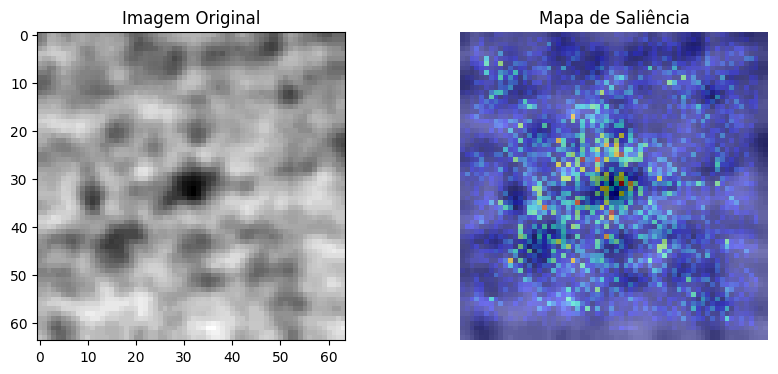

In [50]:
# Escolha uma imagem de teste
img = X_test[0]  # imagem com shape (64, 64, 1)

# Chamada
saliency = saliency_map(model, img)

# Visualização
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title("Imagem Original")

plt.subplot(1,2,2)
plt.imshow(img.squeeze(), cmap='gray')
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.title("Mapa de Saliência")
plt.axis('off')
plt.show()